# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [7]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,(np.union1d(cohorta_mice, cohortb_mice)), return_indices = True) # RF mice 

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
''' Total Number of RF Cells'''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
young_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in RF_aged_mice:
            age_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, age_count)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

10590 10338


# Classify spatial cells using shuffle results OR skip to the next section.

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [ ]:
''' Calculate Spatial Firing Sparsity & Coherence Scores for RF Cells 

OR if you have already run the Figure 5 code, skip to the next cell and load 
these scores.

'''
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/'
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
sparsity_scores = []
spatialcoherence_scores = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session, leave=False):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        #get smoothed FR & sparsity scores
        smoothFR, centers, smoothocc = ps.tuning_curve(posx, Y, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        total_time = max(post) - min(post)
        
        sparsity_scores = []
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(smoothFR[:,i]))
            products = []
            sparsity = []
            for b in range(smoothFR.shape[0]):
                binmeanFRsqr = np.square(smoothFR[b,i])
                prob = smoothocc[b,i]/total_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            sparsity = np.sum(products) / meanFRsqr
            sparsity_scores = np.append(sparsity_scores,sparsity)    
        d['sparsityscores'] = sparsity_scores 
        
        #get non-smoothed FR & spatial coherence scores 
        FR, centers, occ = ps.tuning_curve(posx, Y, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)
        
        spatialcoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = find8adjacentElements(FR[:,i])
            meanFR_neighbors = []
            for b in range(FR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            coherence, p = stats.pearsonr(FR[:,i],meanFR_neighbors)
            if math.isnan(coherence):
                spatialcoherence_scores = np.append(spatialcoherence_scores,0)
            else:
                spatialcoherence_scores = np.append(spatialcoherence_scores,coherence)
        d['spatialcoherencescores'] = spatialcoherence_scores
    
        #Get file names & save scores as npy files
        sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
        spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'

        #np.save(save_folder + sparsityscore_file, sparsity_scores)
        print('saved sparsity scores as npy file for mouse ' + m + ' session '+ s)

        #np.save(save_folder + spatialcoherencescore_file, spatialcoherence_scores)
        print('saved spatial coherence scores as npy file for mouse ' + m + ' session '+ s)

In [11]:
''' Load saved scores to classify spatial cells or use the ones you just generated above

Note : intn boolean & shuffled scores are produced by the notebook "Shuffle Procedure...." Please run that for all sessions 
before proceeding here or use saved scores in Dryad repository.
'''

# adjust paths 
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsity/'
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherence/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust to output of shuffle procedure notebook
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityscore_file = 'shufsparsityscores_' + m + '_' + s + '.npy'
        shufspatialcoherencescore_file = 'shufspatialcoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityscores'] = np.load(shuffload_folder1 + shufsparsityscore_file, allow_pickle=False)
        d['shuffspatialcoherencescores'] = np.load(shuffload_folder2 + shufspatialcoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        
        try:
            _ = d['spatialasparsity'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
            spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'
            
            d['sparsityscores'] = np.load(save_folder + sparsityscore_file, allow_pickle=True)
            d['spatialcoherencescores'] = np.load(save_folder + spatialcoherencescore_file, allow_pickle=True)

  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/3 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/5 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/2 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


In [12]:
''' Classify Spatial Cells from all Sessions: 

Note : shuffled scores are produced by the notebook "Shuffle Procedure." 
Please run that for all sessions before proceeding here.

'''
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
load2_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust path to output of Shuffle Procedure 

per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        d['intn'] = np.load(load2_folder + intn_file, allow_pickle = True)
        cell_IDs = raw.item().get('cellsfil')
        sparsity_scores = d['sparsityscores']
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffsparsityscores = d['shuffsparsityscores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores'] 
        intn = d['intn'].astype(bool)

        #Classify spatial cells as those >P95, >P99 of both sparsity & coherence distributions
        spatialcell99 = []
        spatialcells99 = []
    
        for i, c in enumerate(cell_IDs):
            dist1 = shuffspatialcoherencescores[:,i]
            P991 = np.percentile(dist1,99)

            dist2 = shuffsparsityscores[:,i]
            P992 = np.percentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True:
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialcoherence_scores[i] > P991) & (sparsity_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)

        spatialcell99 = np.asarray(spatialcell99).astype(bool)
        
        d['spatialcells99'] = cell_IDs[spatialcell99]
        d['spatialcell99'] = spatialcell99
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        #np.save(save_folder + spatialcell99_file, spatialcell99)
        #print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P99: ' + str(np.mean(per99c)) + ' ± ' + str(stats.sem(per99c)))  
print('\nMean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Mean ± SEM Coherence P99: 0.44397451511927966 ± 0.001023052553156076

Mean ± SEM Sparsity P99: 0.8021158854819103 ± 0.0022493857825195036


In [23]:
''' Check out distribution of spatial cells '''

per99 = []
sper99 = []
mper99 = []

for m, session in zip(mice,sessions):
    
    m_99 = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all spatial cell boolean
        spatialcell = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell]
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        per99 = np.append(per99, 100*np.sum(spatialcell)/len(cell_IDs))
        sper99 = np.append(sper99, 100*np.sum(spatialcell)/len(cell_IDs))
        m_99 = np.append(m_99, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    mper99 = np.append(mper99, np.sum(m_99)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

A12, 051822_record1 n spatial cells: 86
A12, 051922_record2 n spatial cells: 241
A12, 052022_record3 n spatial cells: 128
A12, 052122_record4 n spatial cells: 62
A12, 052222_record5 n spatial cells: 93
A12, 052322_record6 n spatial cells: 32


  0%|          | 0/6 [00:00<?, ?it/s]

A13, 050522_record1 n spatial cells: 96
A13, 050622_record2 n spatial cells: 297
A13, 050722_record3 n spatial cells: 269
A13, 050822_record4 n spatial cells: 92
A13, 050922_record5 n spatial cells: 26
A13, 051022_record6 n spatial cells: 116


  0%|          | 0/6 [00:00<?, ?it/s]

A3, 0122_record1 n spatial cells: 17
A3, 0123_record2 n spatial cells: 7
A3, 0124_record3 n spatial cells: 15
A3, 0125_record4 n spatial cells: 86
A3, 0126_record5 n spatial cells: 5
A3, 0127_record6 n spatial cells: 29


  0%|          | 0/6 [00:00<?, ?it/s]

A4, 0122_record1 n spatial cells: 71
A4, 0123_record2 n spatial cells: 56
A4, 0124_record3 n spatial cells: 69
A4, 0125_record4 n spatial cells: 139
A4, 0126_record5 n spatial cells: 179
A4, 0127_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

A5, 0401_record1 n spatial cells: 20
A5, 0401_record2b n spatial cells: 81
A5, 0403_record3 n spatial cells: 67
A5, 0404_record4 n spatial cells: 99
A5, 0405_record5 n spatial cells: 16
A5, 0406_record6 n spatial cells: 19


  0%|          | 0/6 [00:00<?, ?it/s]

A6, 0401_record1 n spatial cells: 72
A6, 0402_record2 n spatial cells: 10
A6, 0403_record3 n spatial cells: 19
A6, 0404_record4 n spatial cells: 60
A6, 0405_record5 n spatial cells: 68
A6, 0406_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

A7, 0414_record1 n spatial cells: 82
A7, 0415_record2 n spatial cells: 147
A7, 0416_record3 n spatial cells: 153
A7, 0417_record4 n spatial cells: 158
A7, 0418_record5 n spatial cells: 103
A7, 0419_record6 n spatial cells: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Y11, 050522_record1 n spatial cells: 52
Y11, 050622_record2 n spatial cells: 146
Y11, 050722_record3 n spatial cells: 274
Y11, 050822_record4 n spatial cells: 51
Y11, 051022_record6 n spatial cells: 125


  0%|          | 0/3 [00:00<?, ?it/s]

Y16, 062222_record3 n spatial cells: 54
Y16, 062322_record4 n spatial cells: 6
Y16, 062522_record5 n spatial cells: 1


  0%|          | 0/6 [00:00<?, ?it/s]

Y17, 062822_record1 n spatial cells: 59
Y17, 062922_record2 n spatial cells: 111
Y17, 063022_record3 n spatial cells: 63
Y17, 070122_record4 n spatial cells: 245
Y17, 070222_record5 n spatial cells: 214
Y17, 070322_record6 n spatial cells: 177


  0%|          | 0/6 [00:00<?, ?it/s]

Y18, 062022_record1 n spatial cells: 231
Y18, 062122_record2 n spatial cells: 193
Y18, 062222_record3 n spatial cells: 202
Y18, 062322_record4 n spatial cells: 100
Y18, 062522_record5 n spatial cells: 235
Y18, 062622_record6 n spatial cells: 139


  0%|          | 0/6 [00:00<?, ?it/s]

Y19, 062822_record1 n spatial cells: 102
Y19, 062922_record2 n spatial cells: 106
Y19, 063022_record3 n spatial cells: 78
Y19, 070122_record4 n spatial cells: 190
Y19, 070222_record5 n spatial cells: 205
Y19, 070322_record6 n spatial cells: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Y2, 1024_record1 n spatial cells: 79
Y2, 1025_record2 n spatial cells: 22
Y2, 1026_record3 n spatial cells: 63
Y2, 1027_record4 n spatial cells: 6
Y2, 1028_record5_2 n spatial cells: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Y3, 1016_record1 n spatial cells: 42
Y3, 1019_record3 n spatial cells: 36
Y3, 1020_record4 n spatial cells: 71
Y3, 1021_record5 n spatial cells: 101
Y3, 1022_record6 n spatial cells: 106


  0%|          | 0/6 [00:00<?, ?it/s]

Y4, 1114_record1 n spatial cells: 104
Y4, 1115_record2 n spatial cells: 55
Y4, 1116_record3 n spatial cells: 44
Y4, 1117_record4 n spatial cells: 235
Y4, 1118_record5 n spatial cells: 287
Y4, 1119_record6 n spatial cells: 126


  0%|          | 0/2 [00:00<?, ?it/s]

Y9, 051922_record2 n spatial cells: 7
Y9, 052022_record3 n spatial cells: 0


Mean, SEM Spatial Cell %
38.46812611786303 2.3390964378094172


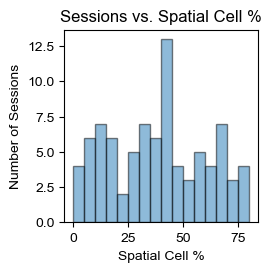

In [20]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Spatial Cell %')
print(np.mean(per99), stats.sem(per99))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.5,2.5), sharey = True)
ax.hist(per99, bins = np.arange(0,85,5), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [21]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
y_ind = []
age_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[age_ind]))
print(len(y_sind), len(age_sind))
Nold = len(mice[age_ind])
Nyoung = len(mice[y_ind])

['Y11' 'Y16' 'Y17' 'Y18' 'Y19' 'Y2' 'Y3' 'Y4' 'Y9'] ['A12' 'A13' 'A3' 'A4' 'A5' 'A6' 'A7']
9 7
44 42


In [25]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,Nold)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,Nyoung)])
col_animal = [col_animal_young, col_animal_old]

col_session_young = []
col_session_old = []
for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in RF_aged_mice:
            idx = np.where(mice == m)[0][0]
            col_session_old.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young,col_session_old]

label_mice = ['Y11', 'Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y3', 'Y4','Y9','A12', 'A13', 'A3', 'A4', 'A5', 'A6', 'A7']

# set up handles
from itertools import repeat
per99 = [mper99[y_ind], mper99[age_ind]]

handles = []
for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)

# Verify classification of spatial cells (Figure 5a-d).

A12


  0%|          | 0/6 [00:00<?, ?it/s]

052022_record3
366


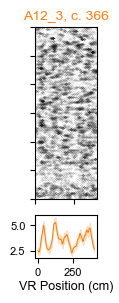

A13


  0%|          | 0/6 [00:00<?, ?it/s]

051022_record6
210


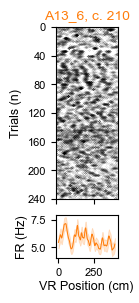

Y18


  0%|          | 0/6 [00:00<?, ?it/s]

062022_record1
398


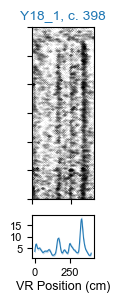

Y19


  0%|          | 0/6 [00:00<?, ?it/s]

062822_record1
740


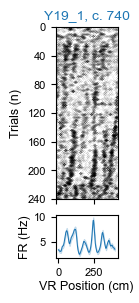

In [40]:
''' Sequentially Plot Example Spatial Cell Rasters with Tuning Curves (Figure 5a)'''

#adjust path
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/examplerasters/'

#set parameters
LW_FR = 0.75
LW_SEM = 0.5
widths = [1]
heights = [1.6,0.4]
dt = 0.02
count = 0
cellcount = 0

#specify cells to use
from matplotlib.lines import Line2D
from copy import copy

ex_mice = ['Y19','Y18','A13','A12'] # mouse names for Fig 5 examples
ex_sessions = ['062822_record1','062022_record1','051022_record6','052022_record3'] #list of sssions

ex_spatialcells = [366,210,398,740]
minimalistbool = [True,False,True,False]
sesh = [3,6,1,1]
cols = ['C1','C1','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    else:
        print(m)
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue
        else:
            print(s)
            
            d = data[m][s]

            #load in data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

            #get behavioral data
            posx = behaviorfil[:,0]
            trials = behaviorfil[:, 2]
            trials = -1 * trials

            # generate aligned position tuning curve
            dt = 0.02
            FR, binned_pos, FR_sem, occ = ps.tuning_curve(posx, Y, dt, b=2, l=2, SEM=True)

            ## PLOT RASTER w/ CONTEXT LABEL
            c = ex_spatialcells[cellcount]
            print(c)
            minimalist = minimalistbool[cellcount]
            col = cols[cellcount]

            fig = plt.figure()
            fig.set_size_inches(0.8,3)
            gs = gridspec.GridSpec(ncols = 1 , nrows = 2, hspace=0.15, figure = fig, width_ratios = widths, height_ratios = heights)

            ax = fig.add_subplot(gs[0, 0])
            sdx = Y[:, np.where(cell_IDs==c)[0][0]].astype(bool)
            ax.plot(posx[sdx], trials[sdx], '.', color = 'k', markersize = 0.2, alpha=0.4)
            ax.tick_params(labelsize = 8)
            ax.set_xlim((0, 400))
            ax.set_ylim((np.min(trials),0))
            ax.set_yticks([-240,-200,-160,-120,-80,-40,0])
            ax.set_yticklabels([240,200,160,120,80,40,0])
            ax.set_title(str(m) + '_' + str(sesh[cellcount]) + ', c. ' + str(c), fontsize = 10, color = col)

            #plot example tuning curve
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            ax1 = fig.add_subplot(gs[1,0])
            ax1.plot(binned_pos, FR[:,sdx], linewidth = LW_FR, color = col)
            ax1.fill_between(binned_pos, FR[:, sdx] + FR_sem[:, sdx], FR[:, sdx] - FR_sem[:, sdx], 
                                 color=col, lw=LW_SEM, alpha=0.2)
            ax1.set_xlabel('VR Position (cm)', fontsize = 9, labelpad = 2)
            ax1.tick_params(labelsize = 8)

            if minimalist:
                ax.tick_params(labelleft=False, labelbottom=False)
            else:
                ax.tick_params(labelleft=True, labelbottom=False)
                #ax.set_xlabel('VR Position (cm)', fontsize = 9)
                ax.set_ylabel('Trials (n)', fontsize = 9)
                ax1.set_ylabel('FR (Hz)', fontsize = 9, labelpad = 2)

            #fig.savefig(save_folder + str(m) + '_' + str(s) + '_rev_' + str(c) + '.png', dpi = 400)
            #fig.savefig(save_folder + str(m) + '_' + str(s) + '_rev_' + str(c) + '.svg', dpi = 400)
            plt.show()

            cellcount += 1

In [42]:
''' For spatial & border cells, save shuffle distributions of sparsity & coherence  '''

spatialsparsity = []
spatialshuffsparsity = []
spatialcoherence = []
spatialshuffcoherence = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        sparsity_scores = d['sparsityscores']
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffsparsityscores = d['shuffsparsityscores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores']
        
        for i, c in enumerate(spatialcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityscores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialcoherencescores[:,sdx]))
            coherence = spatialcoherence_scores[sdx]
            sparsity = sparsity_scores[sdx]
            
            spatialsparsity = np.append(spatialsparsity,sparsity)
            spatialshuffsparsity = np.append(spatialshuffsparsity,shuffsparsity)
            spatialcoherence = np.append(spatialcoherence,coherence)
            spatialshuffcoherence = np.append(spatialshuffcoherence,shuffcoherence)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

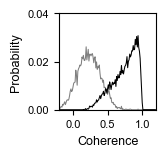


Mean, SEM Real Coherence:
0.7390792074922479 0.0019328191913428486
Mean, SEM Shuffle Coherence:
0.22822880825616557 0.0018206068567523097
stat = 186.0
p_cells = 0.0
n model pairs coherence: 8476


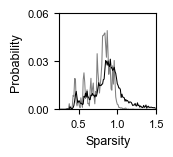


Mean, SEM Real Sparsity:
0.9153549378551794 0.003672820847098984
Mean, SEM Shuffle Sparsity:
0.7716277059911879 0.0016069274931259285
stat = 179.0
p_cells = 0.0
n model pairs sparsity: 8476


In [45]:
''' Plot distribution of randomly selected shuffles vs. real sparsity/coherence; Figure 5B, C '''

bins = np.arange(-0.2,1.2,0.01)
bcoherence, bin_edges = np.histogram(spatialcoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)

shuffcoherence, shuffbin_edges = np.histogram(spatialshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

#Plot Figure 5B
fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(spatialcoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(spatialshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.2])
ax.set_ylim([0,0.04])
ax.set_yticks([0,0.02,0.04])
ax.set_xticks([0,0.5,1.0])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'rfspatialcoherence.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'rfspatialcoherence.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#COHERENCE SPATIAL VS SHUFF
print('\nMean, SEM Real Coherence:')
print(np.nanmean(spatialcoherence), stats.sem(spatialcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle Coherence:')
print(np.nanmean(spatialshuffcoherence), stats.sem(spatialshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialcoherence, spatialshuffcoherence)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))
print('n model pairs coherence: ' + str(len(spatialcoherence[~np.isnan(spatialshuffcoherence)])))

bins = np.arange(0.25,1.5,0.01)

bsparsity, bin_edges = np.histogram(spatialsparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(spatialshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

#Plot Figure 5C
fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0.25,1.5])
ax.set_ylim([0,0.06])
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.03,0.06])
#plt.savefig(save_folder + 'rfspatialsparsity.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'rfspatialsparsity.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#sparsity SPATIAL VS SHUFF
print('\nMean, SEM Real Sparsity:')
print(np.nanmean(spatialsparsity), stats.sem(spatialsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle Sparsity:')
print(np.nanmean(spatialshuffsparsity), stats.sem(spatialshuffsparsity, nan_policy = 'omit')) 

stat, p_diff = stats.wilcoxon(spatialsparsity[~np.isnan(spatialshuffsparsity)], spatialshuffsparsity[~np.isnan(spatialshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))
print('n model pairs sparsity: ' + str(len(spatialsparsity[~np.isnan(spatialshuffsparsity)])))

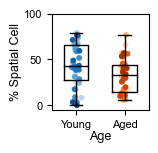

In [46]:
''' Plot Spatial Density by Session across Age Groups (Figure 5D) '''

#spatial Figure 5d
fig, ax = plt.subplots(figsize = (1.25,1.25))
per99 = [sper99[y_sind],sper99[age_sind]]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial Cell', fontsize=9, labelpad=1)
ax.set_ylim([-5,100])
ax.tick_params(labelsize = 8)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
#plt.savefig(save_folder + 'age_spatialdensity_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_spatialdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [48]:
''' Statistically Compare Young vs. Aged Spatial Cell Density '''

print('\nperSC_young ± SEM, perSC_old ± SEM')
print(str(np.round(np.mean(sper99[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper99[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[age_sind]), 2)))

stat, p_diff = stats.ranksums(sper99[y_sind],sper99[age_sind])
print('\np_session, % P99 spatial cell = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind)) + ', ' + str(len(age_sind)))


perSC_young ± SEM, perSC_old ± SEM
44.29 ± 3.52 ; 32.37 ± 2.79

p_session, % P99 spatial cell = 0.01364298972125631
n young, n aged = 44, 42


# Spatial Cell Coherence, Spatial Info, Stability (Figure 5E-G)

In [49]:
'''Store Spatial Coherence & Shuff Coherence Scores'''
dt = 0.02
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/'

scoherence99 = []
sshufcoherence = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spatialcell95_file = 'spatialcell99_' + m + '_' + s + '.npy'
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')

        spatialcell99 = d['spatialcell99']
        spatialcells99 = cell_IDs[spatialcell99]
        
        #get cell IDs, filtered behavioral/spike data, & relevant scores
        cell_IDs = raw.item().get('cellsfil')
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores']
        
        #Calculate Spatial Cell Density
        coherencescore99 = []
        shuffcoherence99 = []
        for i, c in enumerate(spatialcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
    
            coherencescore99 = np.append(coherencescore99,spatialcoherence_scores[sdx])
            shuffcoherence99 = np.append(shuffcoherence99, np.nanmean(np.ravel(shuffspatialcoherencescores[:,sdx])))
            
        #pool data into session arrays    
        scoherence99 = np.append(scoherence99, np.nanmean(coherencescore99))
        sshufcoherence = np.append(sshufcoherence, np.nanmean(shuffcoherence99))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12252\4294928414.py:44: RuntimeWarning: Mean of empty slice
  scoherence99 = np.append(scoherence99, np.nanmean(coherencescore99))
C:\Users\Python\AppData\Local\Temp\ipykernel_12252\4294928414.py:45: RuntimeWarning: Mean of empty slice
  sshufcoherence = np.append(sshufcoherence, np.nanmean(shuffcoherence99))


In [51]:
''' Find where I will have NaNs for Scores, Mean & Peak FR, Slope, Y-Int'''
nan_idx99 = np.where((sper99 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

# Adjust colormaps
yidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list((yidx).astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx), axis = 0)
col_session99 = [col_session_young99, col_session_old99] 

# This will fix session stats & box plots are plotted.

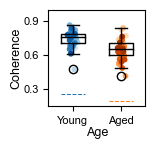

In [52]:
''' Plot Spatial Cell Coherence vs. Shuffle by Age Group (Figure 5E)'''
fig, ax = plt.subplots(figsize = (1.25,1.25))
scoherence99_tog = [scoherence99[y_sind99],scoherence99[age_sind99]]

labels = ['Young','Aged']
w = 0.5

plt.boxplot(scoherence99_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('Mean Coherence', fontsize=9, labelpad=1)
ax.set_ylim([0.15,1])
ax.set_yticks([0.3,0.6,0.9])
ax.tick_params(labelsize = 8)

for i in range(len(scoherence99_tog)):
    y = scoherence99_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1)
ax.hlines(np.mean(sshufcoherence[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshufcoherence[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
#plt.savefig(save_folder + 'age_spatialcoherence_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_spatialcoherence_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [56]:
''' Statistics on Coherence '''
print('Young v. Aged Real Results:')
print('coherenceSC_young ± SEM, coherenceSC_old ± SEM')
print(str(np.round(np.mean(scoherence99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(scoherence99[y_sind99],scoherence99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind99)) + ', ' + str(len(age_sind99)))

print('\nYoung v. Aged Shuffle Results:')
print('shuffcoherenceSC_young ± SEM, shuffcoherenceSC_old ± SEM')
print(str(np.round(np.mean(sshufcoherence[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshufcoherence[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshufcoherence[y_sind99],sshufcoherence[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial shuff coherence = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shuffcoherenceSC_young ± SEM, coherenceSC_young ± SEM')
print(str(np.round(np.mean(sshufcoherence[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufcoherence[y_sind99],scoherence99[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shuffcoherenceSC_old ± SEM, coherenceSC_old ± SEM')
print(str(np.round(np.mean(sshufcoherence[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufcoherence[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(scoherence99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(scoherence99[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufcoherence[age_sind99],scoherence99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial coherence = ' + str(p_diff))

Young v. Aged Real Results:
coherenceSC_young ± SEM, coherenceSC_old ± SEM
0.7425 ± 0.0108 ; 0.648 ± 0.0136
stat = 5.045386221099917
p_session, P99 spatial coherence = 4.5260616809627313e-07
n young, n aged = 43, 42

Young v. Aged Shuffle Results:
shuffcoherenceSC_young ± SEM, shuffcoherenceSC_old ± SEM
0.2517 ± 0.0081 ; 0.193 ± 0.0084
stat = 4.491624318784073
p_session, P99 spatial shuff coherence = 7.068202278383403e-06
n young, n aged = 43, 42

Young Shuffle vs. Real Results:
shuffcoherenceSC_young ± SEM, coherenceSC_young ± SEM
0.2517 ± 0.0081 ; 0.7425 ± 0.0108
stat = 0.0
p_session, P99 spatial coherence = 2.2737367544323206e-13

Aged Shuffle vs. Real Results:
shuffcoherenceSC_old ± SEM, coherenceSC_old ± SEM
0.193 ± 0.0084 ; 0.648 ± 0.0136
stat = 0.0
p_session, P99 spatial coherence = 4.547473508864641e-13


In [57]:
''' Calculate Spatial Information Scores for all Spatial Cells '''

# parameters
track_length = 400 #cm
b = 2 #cm
n_bin = int(track_length/b)
dt = 0.02

sinfo99 = []

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        spatialcells99 = d['spatialcells99']
        total_time = max(post) - min(post)
        
        #provide some track info & calculate smooth spatially binned FR
        smoothFR, _ , smoothocc = ps.tuning_curve(posxfil, Y, dt, b=2, smooth=True, l=2, SEM=False, occupancy = True) #FR shape (n_bins, n_cells)
            
        info99 = []
        for i, c in enumerate(spatialcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            meanFR = np.mean(smoothFR[:,sdx]) #calculate spatial info score
            products = []
            for b in range(0,n_bin):
                binmeanFR = smoothFR[b,sdx]
                div = binmeanFR / meanFR
                if div == 0:
                    products = np.append(products,0)
                else: 
                    log = math.log2(div)
                    prob = smoothocc[b,sdx]/total_time
                    prod = prob*log*div 
                    products = np.append(products,prod)
            info99 = np.append(info99, np.sum(products))  
            
        #pool data into session arrays    
        sinfo99 = np.append(sinfo99, np.nanmean(info99))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12252\574906910.py:54: RuntimeWarning: Mean of empty slice
  sinfo99 = np.append(sinfo99, np.nanmean(info99))


In [58]:
''' Get 1x Spatial Info Shuffle Score for each Cell '''

sshufinfo99 = []

# parameters
track_length = 400 #cm
b = 2 #cm
n_bin = int(track_length/b)
dt = 0.02

for m, session in zip(mice,sessions):
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = find(rawspeed < 2)
        pos_to_trash = find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(spatialcells))) # reset empty shuffled FR matrix    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
            
        #get some data & cell IDs
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #provide some track info & calculate smooth spatially binned FR
        smoothFR, _ , smoothocc = ps.tuning_curve(posxfil, B, dt, b=2, smooth=True, l=2, SEM=False, occupancy = True) #FR shape (n_bins, n_cells)
           
        #get spatial info for shuffle activity
        shuffinfo99 = [] 
        for i, c in enumerate(spatialcells):
            meanFR = np.mean(smoothFR[:,i]) #calculate spatial info score
            products = []
            for b in range(0,n_bin):
                binmeanFR = smoothFR[b,i]
                div = binmeanFR / meanFR
                if div == 0:
                    products = np.append(products,0)
                else: 
                    log = math.log2(div)
                    prob = smoothocc[b,i]/total_time
                    prod = prob*log*div 
                    products = np.append(products,prod)
            shuffinfo99 = np.append(shuffinfo99, np.sum(products)) 
            
        sshufinfo99 = np.append(sshufinfo99, shuffinfo99)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

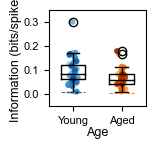

In [59]:
''' Plot Spatial Cell Spatial Information vs. Shuffle by Age Group (Figure 5F) '''
fig, ax = plt.subplots(figsize = (1.25,1.25))
sinfo99_tog = [sinfo99[y_sind99],sinfo99[age_sind99]]

labels = ['Young','Aged']
w = 0.5

plt.boxplot(sinfo99_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('Mean Info. (bits/spike)', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.35])
ax.set_yticks([0,0.1,0.2,0.3])
ax.tick_params(labelsize = 8)

for i in range(len(sinfo99_tog)):
    y = sinfo99_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
ax.hlines(np.mean(sshufinfo99[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshufinfo99[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
#plt.savefig(save_folder + 'age_spatialinfo_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_spatialinfo_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [60]:
''' Statistics on Spatial Information '''
print('Young v. Aged Real Results:')
print('infoSC_young ± SEM, infoSC_old ± SEM')
print(str(np.round(np.mean(sinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sinfo99[y_sind99],sinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))
print('n young, n aged = ' + str(len(y_sind99)) + ', ' + str(len(age_sind99)))

print('\nYoung v. Aged Shuffle Results:')
print('shuffinfoSC_young ± SEM, shuffinfoSC_old ± SEM')
print(str(np.round(np.mean(sshufinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshufinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshufinfo99[y_sind99],sshufinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial shuff info = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shuffinfoSC_young ± SEM, infoSC_young ± SEM')
print(str(np.round(np.mean(sshufinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufinfo99[y_sind99],sinfo99[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shuffinfoSC_old ± SEM, infoSC_old ± SEM')
print(str(np.round(np.mean(sshufinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshufinfo99[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sinfo99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sinfo99[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshufinfo99[age_sind99],sinfo99[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 spatial info = ' + str(p_diff))

Young v. Aged Real Results:
infoSC_young ± SEM, infoSC_old ± SEM
0.0928 ± 0.0081 ; 0.0636 ± 0.0056
stat = 2.94460694088584
p_session, P99 spatial info = 0.0032336517487080827
n young, n aged = 43, 42

Young v. Aged Shuffle Results:
shuffinfoSC_young ± SEM, shuffinfoSC_old ± SEM
0.0076 ± 0.0014 ; 0.0033 ± 0.0006
stat = 3.331361285360398
p_session, P99 spatial shuff info = 0.0008642235955870449

Young Shuffle vs. Real Results:
shuffinfoSC_young ± SEM, infoSC_young ± SEM
0.0076 ± 0.0014 ; 0.0928 ± 0.0081
stat = 1.0
p_session, P99 spatial info = 4.547473508864641e-13

Aged Shuffle vs. Real Results:
shuffinfoSC_old ± SEM, infoSC_old ± SEM
0.0033 ± 0.0006 ; 0.0636 ± 0.0056
stat = 0.0
p_session, P99 spatial info = 4.547473508864641e-13


In [ ]:
''' Calculate Moving Average Stability (k = 5) using Cross-Trial Correlation Matrices for each Spatial Cell '''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/crosstrial/'

def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

for m, session in zip(mice,sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < max_trials): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,max_trials,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, max_trials, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            print(m, s)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(skippedtrials).astype(int)))
            for i, k in enumerate(consec):
                t = np.sort(skippedtrials)[count] 
                print(i,t,k)
                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k
                count += k
        else:
            skippedrawtrialfil = trial.copy()
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        
        #set ticks & text dynamically
        ticks = np.array([0, len(np.unique(skippedrawtrialfil[start_idx:end_idx]))//2 , len(np.unique(skippedrawtrialfil[start_idx:end_idx]))])
        
        #get smoothed by trial FR matrix excluding dark period sorted by context
        normFR, _, _ = tuning_curve_bytrial(posx[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Y[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True) 
        
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allsim'] = allsim
                               
        allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allsim_file, allsim)
        

In [ ]:
''' Calculate Shuffled CTCM for each Spatial Cell '''
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/crosstrial/'

for m, session in zip(mice,sessions):
        
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = find(rawspeed < 2)
        pos_to_trash = find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(spatialcells))) # reset empty shuffled FR matrix    
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < max_trials): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,max_trials,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, max_trials, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            print(m, s)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(skippedtrials).astype(int)))
            for i, k in enumerate(consec):
                t = np.sort(skippedtrials)[count] 
                print(i,t,k)
                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k
                count += k
        else:
            skippedrawtrialfil = trial.copy()
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        
        #set ticks & text dynamically
        ticks = np.array([0, len(np.unique(skippedrawtrialfil[start_idx:end_idx]))//2 , len(np.unique(skippedrawtrialfil[start_idx:end_idx]))])
        
        #get smoothed by trial FR matrix excluding dark period sorted by context
        normFR, _, _ = tuning_curve_bytrial(posx[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], B[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True) 
            
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allshuffsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
        for i, c in enumerate(spatialcells):
            sim , _  = ps.cross_trial_correlation(normFR[:,:,i], shift = False) 
            allshuffsim[:,:,i] = sim
        
        #save shuffled matrix of cross-trial correlations
        d['allshuffsim'] = allshuffsim
                               
        allshuffsim_file = 'allshuffsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allshuffsim_file, allshuffsim)       

In [61]:
''' Load in K-Means Requirements '''

from tqdm import tqdm
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))


In [62]:
''' Regenerate K-Means results for any sessions with onemap = False using optimal k selected in Figure 3 / S4 Notebook '''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/kmeans/'
FRtensor_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/simmatrices/'

yk = []
ak = []
optimalks = []

for m, session in zip(mice, sessions):    
    for s in tdqm(session):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(save_folder + onemapfile)
            
            if onemap[0].astype(bool) == True:
                
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 
                
                optimalks = np.append(optimalks, 1)
                
                if m in RF_aged_mice:
                    ak = np.append(ak, 1)
                else:
                    yk = np.append(yk, 1)
            
            else:
        
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 

                #load optimal k
                SilN_file = 'SilN_' + m + '_' + s + '.npy'
                d['kmeans']['SilN'] = np.load(save_folder + SilN_file)
                SilN = d['kmeans']['SilN']
                
                optimalks = np.append(optimalks, SilN)
            
                if m in RF_aged_mice:
                    ak = np.append(ak, SilN)
                else:
                    yk = np.append(yk, SilN)
                
                #load FR tensor
                FRtensor_file = 'RF_FRtensor_' + m + '_' + s + '.npy'
                d['FRtensor'] = np.load(FRtensor_folder + FRtensor_file)
                Y = d['FRtensor'].copy()
                Y = Y.transpose(0, 2, 1)
                Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
                sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
                sim = squareform(sim_vec)
                d['similarity'] = sim
                
                #run k-means
                model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
                model_kmeans.fit(Y_unwrapped)
                W, H = model_kmeans.factors
                Y_hat = model_kmeans.predict()
                score = model_kmeans.score(Y_unwrapped)
                d['kmeans']['W'] = W
                d['kmeans']['H'] = H
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['score'] = score

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
''' Relabel spatial cell network maps non-arbitrarily (map 0 - 3 == slowest to fastest) '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
    
        #get corrected speed during non-dark & non-gain running
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
        max_trials = np.max(trial)
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < max_trials): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,max_trials,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            #print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, max_trials, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(skippedtrials).astype(int)))
            for i, k in enumerate(consec):
                t = np.sort(skippedtrials)[count] 
                #print(i,t,k)
                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k
                count += k
        else:
            skippedrawtrialfil = trial.copy()
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 200)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
            
        if len(spatialcells) > 10: 
            
            RFspeed = speed[start_idx:end_idx]
            trials = skippedrawtrialfil[start_idx:end_idx]
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(save_folder + onemapfile)
            
            if onemap[0].astype(bool) == False:
                
                #assign map 0 to be the one dominating A, map 1 is the other map
                if (d['kmeans']['SilN'] == 2):
                    W = d['kmeans']['W']

                    # get map indices
                    map_idx = W[:, 0].astype(bool)
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        if map_idx[i]:
                            map0_idx[trials == t] = 1
                        else:
                            map1_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)

                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])

                    if speed_1 < speed_0: # swap labels
                        d['map0_idx'] = 1
                    else:
                        d['map0_idx'] = 0

                #ditto, assign map 1 to be the one dominating B, map 2 is the other map
                elif (d['kmeans']['SilN'] == 3):
                    W = d['kmeans']['W']

                    #get map indices
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    map2_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        map_idx = np.where(W[i,:] == 1)[0][0]
                        if map_idx == 0:
                            map0_idx[trials == t] = 1
                        elif map_idx == 1:
                            map1_idx[trials == t] = 1
                        else:
                            map2_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)
                    map2_idx = map2_idx.astype(bool)

                    # get assign map 0 to be the one with the greate number of trials in Context A
                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])
                    speed_2 = np.nanmean(RFspeed[map2_idx])

                    d['map0_idx'] = np.argmin([speed_0, speed_1, speed_2])
                    d['map2_idx'] = np.argmax([speed_0, speed_1, speed_2])
                    d['map1_idx'] = np.setdiff1d([0,1,2], [d['map0_idx'], d['map2_idx']])[0]

                #ditto but map 2 is the map occupying most of A' map 3 is the other map        
                elif (d['kmeans']['SilN'] == 4):
                    W = d['kmeans']['W']

                    #get map indices
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    map2_idx = np.zeros_like(trials)
                    map3_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        map_idx = np.where(W[i,:] == 1)[0][0]
                        if map_idx == 0:
                            map0_idx[trials == t] = 1
                        elif map_idx == 1:
                            map1_idx[trials == t] = 1
                        elif map_idx == 2:
                            map2_idx[trials == t] = 1
                        else:
                            map3_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)
                    map2_idx = map2_idx.astype(bool)
                    map3_idx = map3_idx.astype(bool)

                    # get assign map 0 to be the one with the greate number of trials in Context A
                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])
                    speed_2 = np.nanmean(RFspeed[map2_idx])
                    speed_3 = np.nanmean(RFspeed[map3_idx])
                    speeds = [speed_0, speed_1, speed_2, speed_3]

                    d['map0_idx'] = np.argmin([speed_0, speed_1, speed_2, speed_3])
                    d['map3_idx'] = np.argmax([speed_0, speed_1, speed_2, speed_3])
                    d['map1_idx'] = np.where(speeds == np.sort(speeds)[1])[0][0]
                    d['map2_idx'] = np.where(speeds == np.sort(speeds)[2])[0][0]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [64]:
''' Getting Moving Avg Similarity across Neighboring 5 Trials within each K-Means Map 

This quantifies stability in a manner that controls explicitly for remapping events.

'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/simmatrices/'
sim_load_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/crosstrial/'
kmeans_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/kmeans/'

slocstab5 = []
max_k = 5

for m, session in zip(mice, sessions):
    m_locstab5 = []
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        trial = behaviorfil[:,2]
        
        #load the cross trial correlation matrices for all spatial cells      
        allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        d['allsim'] = np.load(sim_load_folder + allsim_file)
        allsim = d['allsim']
        
        withinmapstability = [] #avg nearest neighbor stability over all trials within maps for each of the spatial cells
        
        if len(spatialcells) > 10: 
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(kmeans_folder + onemapfile)
            
            if onemap[0].astype(bool) == True:           
            
                for i, c in enumerate(spatialcells):
                    #divide sim by context
                    sim = allsim[:,:,i]
                    sum_k = np.zeros(sim.shape[0])
                    for k in np.arange(-max_k, max_k+1, 1):
                        if k == 0:
                            continue
                        elif k < 0:
                            sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                        else:
                            sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
                    withinmapstability = np.append(withinmapstability, np.mean(sum_k[max_k:-max_k]/(2*max_k)))
                
            else:
                
                if (d['kmeans']['SilN'] == 2):
                    
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[~map_0,:,:]
                    sim1 = sim1[:,~map_0,:]
                    
                    map1stab = []
                    map2stab = []
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = np.append(map1stab, np.mean(sum_k0[max_k:-max_k]/(2*max_k)))
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = np.append(map2stab, np.mean(sum_k1[max_k:-max_k]/(2*max_k)))
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((sum_k0[max_k:-max_k]/(2*max_k),sum_k1[max_k:-max_k]/(2*max_k)))))
                        
                elif (d['kmeans']['SilN'] == 3):
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    map_1 = W[:, d['map1_idx']].astype(bool)
                    map_2 = W[:, d['map2_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[map_1,:,:]
                    sim1 = sim1[:,map_1,:]
                    sim2 = allsim[map_2,:,:]
                    sim2 = sim2[:,map_2,:]
                                                
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = sum_k0[max_k:-max_k]/(2*max_k)
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = sum_k1[max_k:-max_k]/(2*max_k)
                        
                        #map 2 stability
                        sim = sim2[:,:,i]
                        sum_k2 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k2[np.abs(k):] = sum_k2[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k2[:-k] = sum_k2[:-k] + np.diagonal(sim, offset=k)   
                        map3stab = sum_k2[max_k:-max_k]/(2*max_k)
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((map1stab,map2stab,map3stab))))
                    
                elif (d['kmeans']['SilN'] == 4):
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)
                    map_1 = W[:, d['map1_idx']].astype(bool)
                    map_2 = W[:, d['map2_idx']].astype(bool)
                    map_3 = W[:, d['map3_idx']].astype(bool)
                    
                    sim0 = allsim[map_0,:,:]
                    sim0 = sim0[:,map_0,:]
                    sim1 = allsim[map_1,:,:]
                    sim1 = sim1[:,map_1,:]
                    sim2 = allsim[map_2,:,:]
                    sim2 = sim2[:,map_2,:]
                    sim3 = allsim[map_3,:,:]
                    sim3 = sim3[:,map_3,:]
                    
                    for i, c in enumerate(spatialcells):
                        
                        #map 0 stability
                        sim = sim0[:,:,i]
                        sum_k0 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k0[np.abs(k):] = sum_k0[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k0[:-k] = sum_k0[:-k] + np.diagonal(sim, offset=k)   
                        map1stab = sum_k0[max_k:-max_k]/(2*max_k)
                    
                        #map 1 stability
                        sim = sim1[:,:,i]
                        sum_k1 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k1[np.abs(k):] = sum_k1[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k1[:-k] = sum_k1[:-k] + np.diagonal(sim, offset=k)   
                        map2stab = sum_k1[max_k:-max_k]/(2*max_k)
                        
                        #map 2 stability
                        sim = sim2[:,:,i]
                        sum_k2 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k2[np.abs(k):] = sum_k2[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k2[:-k] = sum_k2[:-k] + np.diagonal(sim, offset=k)   
                        map3stab = sum_k2[max_k:-max_k]/(2*max_k)
                        
                        #map 3 stability
                        sim = sim3[:,:,i]
                        sum_k3 = np.zeros(sim.shape[0])
                        for k in np.arange(-max_k, max_k+1, 1):
                            if k == 0:
                                continue
                            elif k < 0:
                                sum_k3[np.abs(k):] = sum_k3[np.abs(k):] + np.diagonal(sim, offset=k)
                            else:
                                sum_k3[:-k] = sum_k3[:-k] + np.diagonal(sim, offset=k)   
                        map4stab = sum_k3[max_k:-max_k]/(2*max_k)
                        
                        withinmapstability = np.append(withinmapstability, np.mean(np.concatenate((map1stab,map2stab,map3stab,map4stab))))
                                          
        else: 
            
            for i, c in enumerate(spatialcells):
                #divide sim by context
                sim = allsim[:,:,i]
                sum_k = np.zeros(sim.shape[0])
                for k in np.arange(-max_k, max_k+1, 1):
                    if k == 0:
                        continue
                    elif k < 0:
                        sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                    else:
                        sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
                withinmapstability = np.append(withinmapstability, np.mean(sum_k[max_k:-max_k]/(2*max_k)))
                
        # save out within map stability to relate to position decoding accuracy
        within_map_stability_file = 'within_map_stab_' + m + '_' + s + '.npy'
        np.save(save_folder + within_map_stability_file, withinmapstability)
        
        #report out results
        slocstab5 = np.append(slocstab5, np.mean(withinmapstability)) #mean over all cells in a sesssion

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [65]:
''' Getting Moving Avg Similarity as a Measure of Stability for Shuffle Data '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/simmatrices/'
sim_load_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellsrf/crosstrial/'

sshuflocstab5 = []
max_k = 5

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        #load the cross trial correlation matrices for all spatial cells      
        allshuffsim_file = 'allshuffsim_' + m + '_' + s + '_'+ '.npy'
        d['allshuffsim'] = np.load(sim_load_folder + allshuffsim_file)
        allshuffsim = d['allshuffsim']
        
        local_stability5 = []
        for i, c in enumerate(spatialcells):
            
            #divide sim by context
            sim = allshuffsim[:,:,i]
        
            #local neighborhood 5 trials
            sum_k = np.zeros(sim.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(sim, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(sim, offset=k)
            local_stability5 = np.append(local_stability5, np.mean(sum_k[max_k:-max_k]/(2*max_k)))

        #save session results
        sshuflocstab5 = np.append(sshuflocstab5, np.nanmean(local_stability5))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12252\1826842288.py:47: RuntimeWarning: Mean of empty slice
  sshuflocstab5 = np.append(sshuflocstab5, np.nanmean(local_stability5))


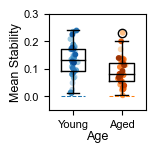

In [68]:
''' Plot Within Map Stability across Age Groups (Figure 5G) '''

labels = ['Young','Aged']
w = 0.5

fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.25), sharey = True)
#fig.suptitle('Spatial Cell Within Map Stability, Pooled by Age Group', fontsize=12)

slocstab5_tog = [slocstab5[y_sind99],slocstab5[age_sind99]]
ax.boxplot(slocstab5_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(sshuflocstab5[y_sind99]), 0.75, 1.25, color = 'C0', linestyle ='dashed', linewidth = 0.75, label = 'Young Shuffle')
ax.hlines(np.mean(sshuflocstab5[age_sind99]), 1.75, 2.25, color = 'C1', linestyle ='dashed', linewidth = 0.75, label = 'Aged Shuffle')
#ax.set_title('Session Spatial Cell Within Map Stability k = 5', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Stability', fontsize=9, labelpad=1)

for i in range(len(slocstab5_tog)):
    y = slocstab5_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], alpha = 1, s = 10)

ax.set_ylim([-0.05,0.3])
ax.set_yticks([0,0.1,0.2,0.3])
ax.tick_params(labelsize = 8)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
#plt.savefig(save_folder + 'age_spatialwithinmapstab_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_spatialwithinmapstab_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [71]:
''' Statistics on Mean locstab5 '''

print('\nWithin Map locstab5 Young vs. Aged RESULTS:')
print('locstabyoung ± SEM; locstab_old ± SEM')
print(str(np.round(np.mean(slocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[age_sind99]), 4)))

stat, p_diff = stats.ranksums(slocstab5[y_sind99],slocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, locstab5 = ' + str(p_diff))

print('\nWithin Map locstab5 Shuffle Young vs. Aged RESULTS:')
print('shuflocstabyoung ± SEM; shuflocstab_old ± SEM')
print(str(np.round(np.mean(sshuflocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sshuflocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[age_sind99]), 4)))

stat, p_diff = stats.ranksums(sshuflocstab5[y_sind99],sshuflocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, shuff locstab5 = ' + str(p_diff))

print('\nYoung Shuffle vs. Real Results:')
print('shufflocstab5SC_young ± SEM, locstab5SC_young ± SEM')
print(str(np.round(np.mean(sshuflocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[y_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshuflocstab5[y_sind99],slocstab5[y_sind99])
print('stat = ' + str(stat))
print('p_session, P99 locstab5 = ' + str(p_diff))

print('\nAged Shuffle vs. Real Results:')
print('shufflocstab5SC_old ± SEM, locstab5SC_old ± SEM')
print(str(np.round(np.mean(sshuflocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sshuflocstab5[age_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(slocstab5[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(slocstab5[age_sind99]), 4)))

stat, p_diff = stats.wilcoxon(sshuflocstab5[age_sind99],slocstab5[age_sind99])
print('stat = ' + str(stat))
print('p_session, P99 locstab5 = ' + str(p_diff))


Within Map locstab5 Young vs. Aged RESULTS:
locstabyoung ± SEM; locstab_old ± SEM
0.1314 ± 0.0087 ; 0.0895 ± 0.0075
stat = 3.647796658112309
p_session, locstab5 = 0.0002644988343191263

Within Map locstab5 Shuffle Young vs. Aged RESULTS:
shuflocstabyoung ± SEM; shuflocstab_old ± SEM
0.0006 ± 0.0003 ; 0.0007 ± 0.0004
stat = -0.6328707455038224
p_session, shuff locstab5 = 0.5268180531942035

Young Shuffle vs. Real Results:
shufflocstab5SC_young ± SEM, locstab5SC_young ± SEM
0.0006 ± 0.0003 ; 0.1314 ± 0.0087
stat = 0.0
p_session, P99 locstab5 = 2.2737367544323206e-13

Aged Shuffle vs. Real Results:
shufflocstab5SC_old ± SEM, locstab5SC_old ± SEM
0.0007 ± 0.0004 ; 0.0895 ± 0.0075
stat = 0.0
p_session, P99 locstab5 = 4.547473508864641e-13


# Compare position decoding accuracy from young vs. aged spatial network activity (Figure 5H - J)